In [293]:
import os, cv2, numpy as np, torch
from PIL import Image, ImageDraw

root_dir = "E:\Pycharm\Advanced-Reading-on-Computer-Vision\Images"
IMG_PATH = root_dir + 'street2.jpg'
if not os.path.exists(IMG_PATH):
    img = Image.new('RGB', (960, 640), (235, 240, 245))
    d = ImageDraw.Draw(img)
    for (x, y, w, h) in [(120, 300, 120, 80), (420, 280, 90, 70), (700, 320, 160, 100)]:
        d.rectangle([x, y, x + w, y + h], outline=(60, 60, 60), width=4)
    d.text((20, 20), "Dummy Street-like Scene", fill=(10, 10, 10))
    img.save(IMG_PATH)
# GT boxes (xyxy) — ví dụ tay (bạn thay bằng GT thật nếu có)
GT = np.array([
    [90, 780, 210, 965],  # object 1
    [500, 760, 615, 860],  # object 2
    [1100, 750, 1230, 875],  # object 3
], dtype=np.float32)


def draw_boxes(path, boxes, color=(0, 255, 0), labels=None, scores=None, th=0.0):
    im = cv2.imread(path)
    for i, b in enumerate(boxes):
        if scores is not None and scores[i] < th:
            continue
        x1, y1, x2, y2 = map(int, b)
        cv2.rectangle(im, (x1, y1), (x2, y2), color, 2)
        if labels is not None or scores is not None:
            txt = ''
            if labels is not None: txt += str(labels[i])
            if scores is not None: txt += f" {scores[i]:.2f}"
            if txt: cv2.putText(im, txt, (x1, max(0, y1 - 6)), cv2.FONT_HERSHEY_SIMPLEX,

                                0.6, color, 2)
    return im

In [294]:
import torch


def box_xyxy_to_xywh(b):
    x1, y1, x2, y2 = b.unbind(-1)
    w = x2 - x1;
    h = y2 - y1
    cx = x1 + 0.5 * w;
    cy = y1 + 0.5 * h
    return torch.stack([cx, cy, w, h], dim=-1)


def box_xywh_to_xyxy(b):
    cx, cy, w, h = b.unbind(-1)
    x1 = cx - 0.5 * w;
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w;
    y2 = cy + 0.5 * h
    return torch.stack([x1, y1, x2, y2], dim=-1)


def iou(boxes1, boxes2):
    # boxes*: [N,4] (xyxy)
    tl = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N, M, 2]
    br = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    wh = (br - tl).clamp(min=0)
    inter = wh[..., 0] * wh[..., 1]
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
    union = area1[:, None] + area2 - inter
    return inter / (union + 1e-7)


# SSD encode/decode (theo tỉ lệ offsets và log-scale)
def ssd_encode(gt_xyxy, anchors_xywh, variances=(0.1, 0.2)):
    gt_xywh = box_xyxy_to_xywh(gt_xyxy)
    g_cxcy = (gt_xywh[:, :2] - anchors_xywh[:, :2]) / anchors_xywh[:, 2:]
    g_wh = torch.log(gt_xywh[:, 2:] / anchors_xywh[:, 2:])
    v1, v2 = variances
    return torch.cat([(g_cxcy / v1), (g_wh / v2)], dim=-1)


def ssd_decode(pred_t, anchors_xywh, variances=(0.1, 0.2)):
    v1, v2 = variances
    cxcy = pred_t[:, :2] * v1 * anchors_xywh[:, 2:] + anchors_xywh[:, :2]
    wh = torch.exp(pred_t[:, 2:] * v2) * anchors_xywh[:, 2:]
    return box_xywh_to_xyxy(torch.cat([cxcy, wh], dim=-1))

## B.1 IoU & GIoU/DIoU/CIoU + Encode/Decode (SSD)

torch.Size([3, 480])
Max L1 decode error: 0.0


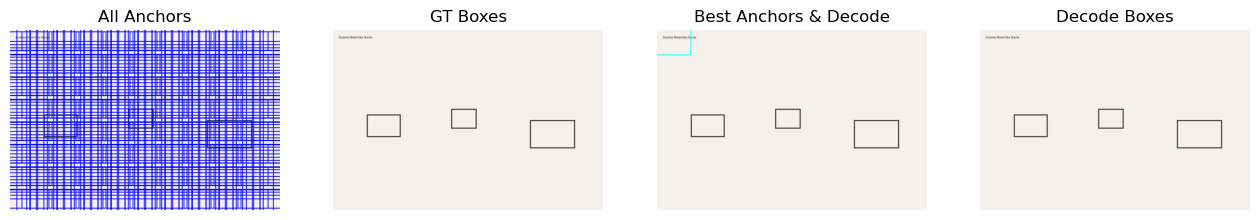

In [295]:
# anchors demo (tạo grid đơn giản)
im = cv2.imread(IMG_PATH)
H, W, chal_ = im.shape
feat_h, feat_w = 8, 10  # stride ~32
stride_y, stride_x = H / feat_h, W / feat_w
scales = [0.15, 0.25]
ratios = [1.0, 2.0, 0.5]
anchors = []

for y in range(feat_h):
    for x in range(feat_w):
        cy = (y + 0.5) * stride_y
        cx = (x + 0.5) * stride_x
        for s in scales:
            for r in ratios:
                w = W * s * (r ** 0.5)
                h = H * s / (r ** 0.5)
                anchors.append([cx - 0.5 * w, cy - 0.5 * h, cx + 0.5 * w, cy + 0.5 * h])
anchors = torch.tensor(anchors, dtype=torch.float32)
gt = torch.tensor(GT, dtype=torch.float32)

IOU = iou(gt, anchors)  # [n_gt, n_anchor]
print(IOU.shape)
best_idx = IOU.argmax(dim=1)  # anchor tốt nhất cho mỗi GT
best_anchors = anchors[best_idx]


# SSD encode/decode
def ssd_encode(gt_xyxy, anc_xyxy, variances=(0.1, 0.2)):
    v1, v2 = variances
    gt_xywh = box_xyxy_to_xywh(gt_xyxy)
    anc_xywh = box_xyxy_to_xywh(anc_xyxy)
    t_xy = (gt_xywh[:, :2] - anc_xywh[:, :2]) / anc_xywh[:, 2:]
    t_wh = torch.log(gt_xywh[:, 2:] / anc_xywh[:, 2:])
    return torch.cat([t_xy / v1, t_wh / v2], dim=-1)


def ssd_decode(t, anc_xyxy, variances=(0.1, 0.2)):
    v1, v2 = variances
    anc_xywh = box_xyxy_to_xywh(anc_xyxy)
    cxcy = t[:, :2] * v1 * anc_xywh[:, 2:] + anc_xywh[:, :2]
    wh = torch.exp(t[:, 2:] * v2) * anc_xywh[:, 2:]
    return box_xywh_to_xyxy(torch.cat([cxcy, wh], dim=-1))


t = ssd_encode(gt, best_anchors)
gt_rec = ssd_decode(t, best_anchors)
print('Max L1 decode error:', (gt_rec - gt).abs().max().item())

# Vẽ GT (xanh) & anchor tốt nhất (vàng) & decode (lục)
anchors_img = draw_boxes(IMG_PATH, anchors.numpy(), color=(0, 0, 255))

GT_img = draw_boxes(IMG_PATH, GT, color=(0, 255, 0))

best_anchors_img = draw_boxes(IMG_PATH, best_anchors.numpy(), color=(0, 255, 255))

gt_rec_img = draw_boxes(IMG_PATH, gt_rec.numpy(), color=(0, 255, 0))

from matplotlib import pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(1, 4, 1)
plt.imshow(anchors_img)
plt.title('All Anchors')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(GT_img)
plt.title('GT Boxes')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(best_anchors_img)
plt.title('Best Anchors & Decode')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(gt_rec_img)
plt.title('Decode Boxes')
plt.axis('off')
plt.show()


## B.2 NMS vs Soft-NMS trên cùng ảnh (dùng boxes giả lập)

NMS keep: [2, 0, 3] | Soft-NMS keep: [2, 0, 3, 1]


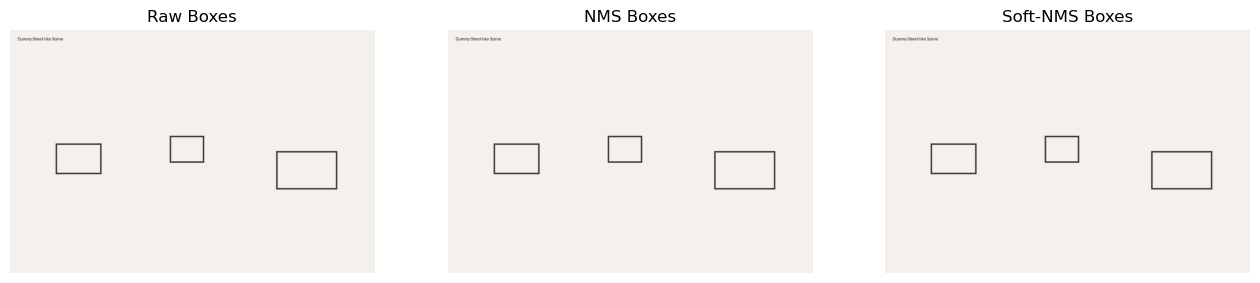

In [296]:
# boxes “raw” bị chồng lấn + confidence
boxes = torch.tensor([
    [93, 781, 212, 960],  # gần GT1
    [1080,755, 1200,869],  # trùng mạnh
    [503, 758, 611, 862],  # gần GT2
    [1097, 752, 1228, 873],  # gần GT3
], dtype=torch.float32)

scores = torch.tensor([0.88, 0.81, 0.92, 0.84], dtype=torch.float32)

def iou_one(a, b):
    tl = torch.max(a[:2], b[:2]); br = torch.min(a[2:], b[2:])
    wh = (br - tl).clamp(min=0); inter = wh[0]*wh[1]
    area1=(a[2]-a[0])*(a[3]-a[1]); area2=(b[2]-b[0])*(b[3]-b[1])
    return inter/(area1+area2-inter+1e-7)

def nms(boxes, scores, th=0.5):
    keep=[]; idx = scores.argsort(descending=True)
    while idx.numel()>0:
        i = idx[0]; keep.append(i.item())
        if idx.numel()==1: break
        ov = torch.stack([iou_one(boxes[i], boxes[j]) for j in idx[1:]])
        idx = idx[1:][ov<=th]
    return keep

def soft_nms(boxes, scores, th=0.5, sigma=0.5, score_th=0.001):
    idx = scores.argsort(descending=True)
    b = boxes.clone(); s = scores.clone(); keep=[]
    while idx.numel()>0:
        i = idx[0]; keep.append(i.item())
        if idx.numel()==1: break
        others = idx[1:]
        ov = torch.stack([iou_one(b[i], b[j]) for j in others])
        s[others] = s[others]*torch.exp(-(ov**2)/sigma)
        idx = others[s[others]>score_th]
        idx = idx[s[idx].argsort(descending=True)]
    return keep

k1 = nms(boxes, scores, 0.5)
k2 = soft_nms(boxes, scores, 0.5, 0.5, 0.05)
print('NMS keep:', k1, '| Soft-NMS keep:', k2)

a2_raw = draw_boxes(IMG_PATH, boxes.numpy(), scores=scores.numpy())
a2_nms = draw_boxes(IMG_PATH, boxes.numpy()[k1], scores=scores.numpy()[k1], color=(0,255,0))
a2_softnms = draw_boxes(IMG_PATH, boxes.numpy()[k2], scores=scores.numpy()[k2], color=(0,0,255))

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(a2_raw); plt.title('Raw Boxes'); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(a2_nms);plt.title('NMS Boxes'); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(a2_softnms); plt.title('Soft-NMS Boxes'); plt.axis('off')
plt.show()


## B.3 Anchors / Grid YOLO (trực quan hóa tâm lưới + anchor Boxes)

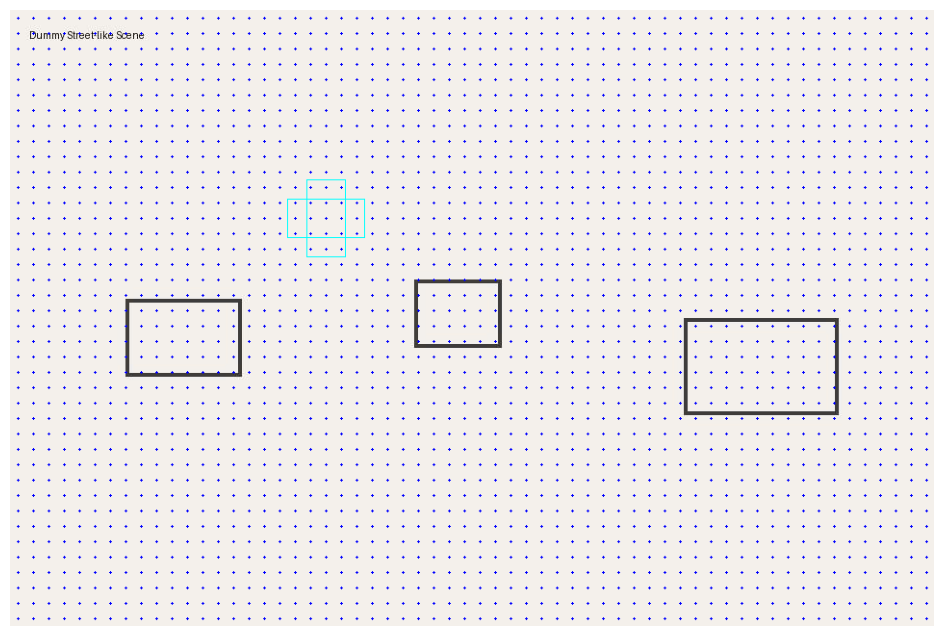

In [297]:
im = cv2.imread(IMG_PATH)
H, W, chal_ = im.shape

feat_h, feat_w, stride = 40, 60, 16  # ví dụ P3 stride 16
yv, xv = torch.meshgrid(torch.arange(feat_h), torch.arange(feat_w), indexing='ij')
grid = torch.stack((xv, yv), 2).view(-1,2).float()
centers = (grid + 0.5) * stride  # (N,2) pixel

# Vẽ 200 tâm đầu tiên
im = cv2.imread(IMG_PATH)
for cx,cy in centers[:]:
    cv2.circle(im, (int(cx),int(cy)), 1, (0,0,255), -1)

# Vẽ 1-2 anchor rectangles quanh một tâm chọn
cx,cy = centers[800]  # tùy ô
for w,h in [(40,40),(80,40),(40,80)]:
    x1,y1 = int(cx - w/2), int(cy - h/2)
    x2,y2 = int(cx + w/2), int(cy + h/2)
    cv2.rectangle(im,(x1,y1),(x2,y2),(0,255,255),1)

plt.figure(figsize=(12,8))
plt.imshow(im)
plt.axis('off')
plt.show()

## B.4 FPN: trực quan “độ kích hoạt” (heatmap) trên các mức P3/P4/P5

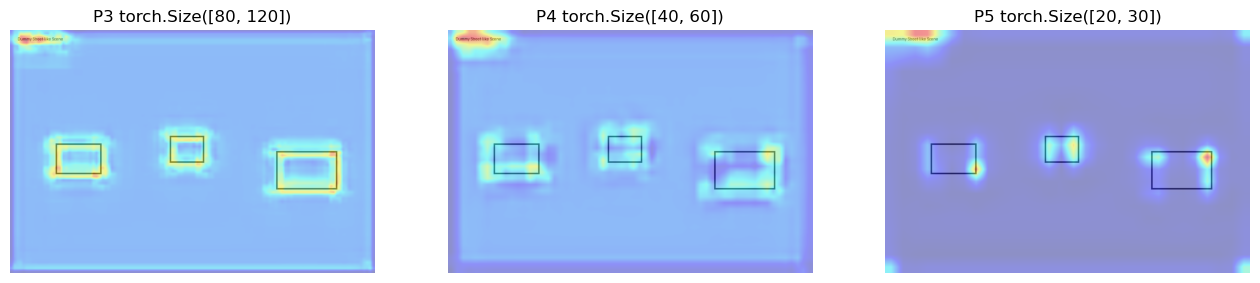

In [298]:
# ==== A.4 (FIXED) FPN: trực quan “độ kích hoạt” P3/P4/P5 ====
import cv2, numpy as np, torch, torch.nn as nn
import torch.nn.functional as F
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# 1) Đọc ảnh an toàn (tránh stride âm)

img_bgr = cv2.imread(IMG_PATH)
assert img_bgr is not None, f"Không đọc được ảnh: {IMG_PATH}"
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# (Tuỳ chọn) pad ảnh để H, W chia hết cho 32 giúp downsample ổn định hơn
def pad_to_divisible(im, div=32):
    h, w = im.shape[:2]
    nh = (h + div - 1) // div * div
    nw = (w + div - 1) // div * div
    if (nh, nw) == (h, w):
        return im
    pad_b = nh - h
    pad_r = nw - w
    # Pad phía dưới/phải để không lệch nội dung
    return cv2.copyMakeBorder(im, 0, pad_b, 0, pad_r, borderType=cv2.BORDER_REPLICATE)

img = pad_to_divisible(img, 32)
t = torch.from_numpy(img).permute(2,0,1).float()/255.0
t = t.unsqueeze(0)

# 2) Backbone nhẹ để demo
base = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT).features.eval()

# Lấy vài mốc làm "C3/C4/C5" (chỉ để minh hoạ; MobileNet không có C-stages chuẩn như ResNet)
# Bạn có thể đổi danh sách taps tuỳ phiên bản torchvision
taps = [3, 6, 12]  # các chỉ số layer trong base.features
def extract_c3c4c5(x):
    feats = {}
    y = x
    for i, m in enumerate(base):
        y = m(y)
        if i in taps:
            feats[i] = y
    # đảm bảo đủ 3 mức
    assert all(k in feats for k in taps), f"Không lấy đủ taps {taps}, có {list(feats.keys())}"
    return feats[taps[0]], feats[taps[1]], feats[taps[2]]

with torch.no_grad():
    C3, C4, C5 = extract_c3c4c5(t)

class SimpleFPN(nn.Module):
    def __init__(self, c3, c4, c5, out=128):
        super().__init__()
        self.l3 = nn.Conv2d(c3, out, 1)
        self.l4 = nn.Conv2d(c4, out, 1)
        self.l5 = nn.Conv2d(c5, out, 1)
        self.s3 = nn.Conv2d(out, out, 3, padding=1)  # <-- dùng padding, không phải p=
        self.s4 = nn.Conv2d(out, out, 3, padding=1)

    def forward(self, C3, C4, C5):
        P5 = self.l5(C5)
        #  UpSample theo kích thước chuẩn của nhánh lateral để tránh lệch 1 pixel
        P4 = self.l4(C4) + F.interpolate(P5, size=C4.shape[-2:], mode='nearest')
        P3 = self.l3(C3) + F.interpolate(P4, size=C3.shape[-2:], mode='nearest')
        P4 = self.s4(P4)
        P3 = self.s3(P3)
        return P3, P4, P5

with torch.no_grad():
    fpn = SimpleFPN(C3.shape[1], C4.shape[1], C5.shape[1], out=64).eval()
    P3, P4, P5 = fpn(C3, C4, C5)

# 3) Vẽ heatmap
def heat_to_img(h, base_img_bgr):
    # h: [1,C,H,W] -> trung bình kênh -> normalize -> resize -> overlay
    hm = h.abs().mean(1, keepdim=True)  # [1,1,H,W]
    hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-7)
    hm = hm[0,0].cpu().numpy()
    H, W = base_img_bgr.shape[:2]
    hm = cv2.resize(hm, (W, H))
    heat = (hm*255).astype(np.uint8)
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
    blend = cv2.addWeighted(base_img_bgr, 0.6, heat, 0.4, 0)

    return blend


base_img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

a4_p3_img = heat_to_img(P3, base_img_bgr)
a4_p4_img = heat_to_img(P4, base_img_bgr)
a4_p5_img = heat_to_img(P5, base_img_bgr)

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(a4_p3_img, cv2.COLOR_BGR2RGB))
plt.title(f'P3 {P3.shape[-2:]}'); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(a4_p4_img, cv2.COLOR_BGR2RGB))
plt.title(f'P4 {P4.shape[-2:]}'); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(a4_p5_img, cv2.COLOR_BGR2RGB))
plt.title(f'P5 {P5.shape[-2:]}'); plt.axis('off')
plt.show()


## B.5 “Head” SSD: kiểm tra hình dạng đầu ra (cls/reg) & sanity box-regression

cls_out: torch.Size([1, 14400, 5]) reg_out: torch.Size([1, 14400, 4])


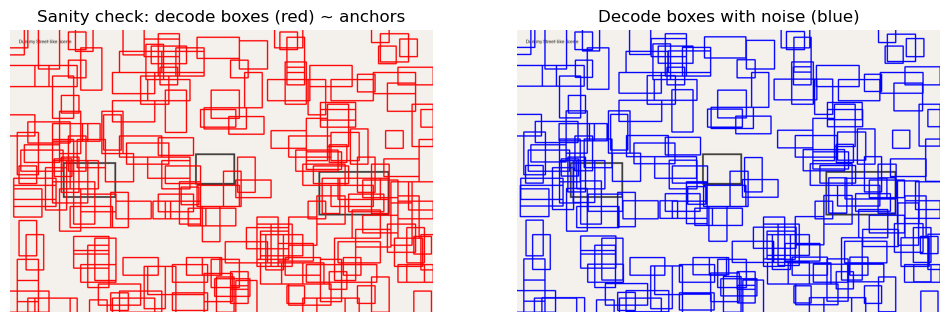

In [299]:
import torch.nn as nn

class SSDHeadDemo(nn.Module):
    def __init__(self, in_ch, num_anchors, num_classes):
        super().__init__()
        self.cls = nn.Conv2d(in_ch, num_anchors*num_classes, 3, padding=1)
        self.reg = nn.Conv2d(in_ch, num_anchors*4, 3, padding=1)
    def forward(self, f):
        B,C,H,W = f.shape
        cls = self.cls(f).permute(0,2,3,1).contiguous().view(B, -1, num_classes)
        reg = self.reg(f).permute(0,2,3,1).contiguous().view(B, -1, 4)
        return cls, reg

num_classes = 4+1   # background + 4 lớp ví dụ
num_anchors = 6     # ví dụ 6 anchor/mỗi ô
fake_feat = torch.randn(1, 64, 40, 60)  # giống P3 ở trên
head = SSDHeadDemo(64, num_anchors, num_classes)
cls_out, reg_out = head(fake_feat)
print('cls_out:', cls_out.shape, 'reg_out:', reg_out.shape)  # -> (1, H*W*num_anchors, num_classes) & (1, *, 4)

# Sanity: thử reg_out + anchors -> decode ra boxes, rồi vẽ thử
# Tạo anchors tương ứng với (H,W) và stride ~16 như A.3
#H,W = 640,960; feat_h,feat_w,stride = 40,60,16

im = cv2.imread(IMG_PATH)
H, W, chal_ = im.shape
feat_h,feat_w,stride = 40,60,16

yv,xv = torch.meshgrid(torch.arange(feat_h), torch.arange(feat_w), indexing='ij')
centers = (torch.stack((xv,yv),2).view(-1,2).float()+0.5)*stride
anchors=[]
for (w,h) in [(40,40),(80,40),(40,80),(64,64),(96,48),(48,96)]:
    cxcywh = torch.cat([centers, torch.full_like(centers, w), torch.full_like(centers, h)], dim=1)
    # nhưng cần (cx,cy,w,h) — chuyển sang xyxy:
    for i in range(cxcywh.shape[0]):
        cx,cy= cxcywh[i,0], cxcywh[i,1]
        anchors.append([cx-0.5*w, cy-0.5*h, cx+0.5*w, cy+0.5*h])
anchors = torch.tensor(anchors, dtype=torch.float32)

# Lấy N điểm reg bất kỳ & giả lập decode (dùng ssd_decode ở A.1)
def ssd_decode_xyxy(t, anc_xyxy, v=(0.1,0.2)):
    v1,v2=v
    def xyxy2xywh(b):
        x1,y1,x2,y2 = b.unbind(-1); w=x2-x1; h=y2-y1
        cx=x1+0.5*w; cy=y1+0.5*h
        return torch.stack([cx,cy,w,h],-1)
    def xywh2xyxy(b):
        cx,cy,w,h = b.unbind(-1)
        x1=cx-0.5*w; y1=cy-0.5*h; x2=cx+0.5*w; y2=cy+0.5*h
        return torch.stack([x1,y1,x2,y2],-1)
    anc = xyxy2xywh(anc_xyxy)
    cxcy = t[:,:2]*v1*anc[:,2:] + anc[:,:2]
    wh   = torch.exp(t[:,2:]*v2)*anc[:,2:]
    return xywh2xyxy(torch.cat([cxcy,wh],-1))

sel = torch.randint(0, reg_out.shape[1], (200,))  # 200 anchor ngẫu nhiên
reg_sel = reg_out[0, sel] * 0.0  # đặt offset=0 để decode ~ về chính anchor (sanity)
boxes_dec = ssd_decode_xyxy(reg_sel, anchors[sel])
#draw_boxes(IMG_PATH, boxes_dec.numpy(), color=(255,0,0), out=root_dir +'runs_demo/a5_head_sanity.jpg')

a5_head_sanity = draw_boxes(IMG_PATH, boxes_dec.detach().numpy(), color=(255,0,0))

import torch
# Add small noise to reg_sel
reg_sel_noisy = reg_sel + 0.05 * torch.randn_like(reg_sel)

# Decode with noise
boxes_dec_noisy = ssd_decode_xyxy(reg_sel_noisy, anchors[sel])

# Visualize
a5_head_sanity_noisy = draw_boxes(IMG_PATH, boxes_dec_noisy.detach().numpy(), color=(0,0,255))

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(a5_head_sanity)
plt.title('Sanity check: decode boxes (red) ~ anchors')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(a5_head_sanity_noisy)
plt.title('Decode boxes with noise (blue)')
plt.axis('off')
plt.show()

## Bài tập mở rộng:
Dùng pretrained YOLOv7 (hoặc v8) chạy inference -> lấy boxes, scores thật trên ảnh rồi áp Soft-NMS (B.2) để thấy khác biệt rõ hơn.
- Thử tile-based detection: chia ảnh lớn thành ô 1024×1024, ghép kết quả và áp NMS toàn cục.
- Với FPN: thay backbone khác (ResNet50) và đổi "tap points" để xem heatmap P3/P4/P5 khác nhau thế nào.


In [300]:
import ultralytics
from ultralytics import YOLO

model = YOLO('yolov8n.pt')


image 1/1 E:\Pycharm\Advanced-Reading-on-Computer-Vision\Images\street2.jpg: 448x640 3 persons, 6 cars, 1 umbrella, 32.0ms
Speed: 1.9ms preprocess, 32.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)
Original detections: 10
After NMS: 10
After Soft-NMS: 10


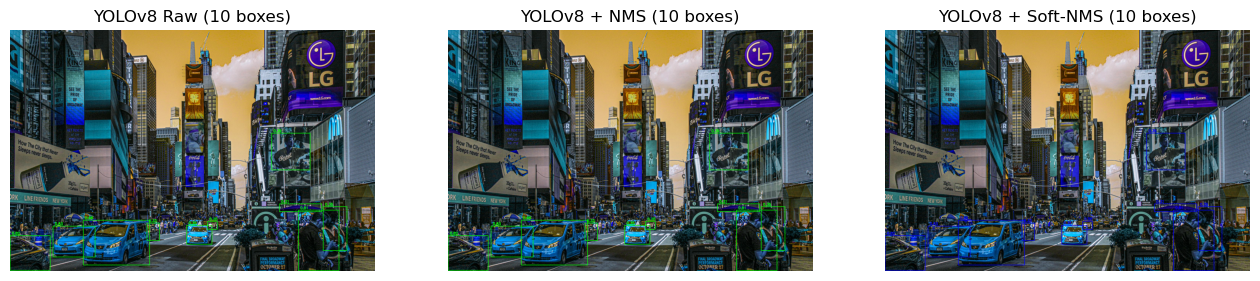

In [301]:
IMG_PATH = root_dir + '\street2.jpg'
results = model(IMG_PATH)


result = results[0]
boxes_yolo = result.boxes.xyxy
scores_yolo = result.boxes.conf

boxes_yolo_torch = torch.tensor(boxes_yolo.tolist())
scores_yolo_torch = torch.tensor(scores_yolo.tolist())

def soft_nms(boxes, scores, iou_th=0.5, sigma=0.5, score_th=0.001):
    idxs = scores.argsort(descending=True)
    b = boxes.clone(); s = scores.clone(); keep=[]
    while idxs.numel()>0:
        i = idxs[0]; keep.append(i.item())
        if idxs.numel()==1: break
        others = idxs[1:]
        ov = iou(b[i].unsqueeze(0), b[others]).squeeze(0) # Sử dụng hàm iou đã định nghĩa ở trên
        weights = torch.exp(-(ov**2)/sigma)
        s[others] = s[others]*weights
        idxs = others[s[others]>score_th]
        idxs = idxs[s[idxs].argsort(descending=True)]
    return keep

def nms(boxes, scores, iou_th=0.5):
    keep = []
    idxs = scores.argsort(descending=True)
    while idxs.numel() > 0:
        i = idxs[0]; keep.append(i.item())
        if idxs.numel() == 1: break
        iou_vals = iou(boxes[i].unsqueeze(0), boxes[idxs[1:]]).squeeze(0)
        idxs = idxs[1:][iou_vals <= iou_th]
    return keep
# Use the soft_nms function defined earlier (cell_id: bab43666-eb03-4a87-8044-60d9e1fef90c)
keep_soft_nms = soft_nms(boxes_yolo_torch, scores_yolo_torch, iou_th=0.5, sigma=0.5, score_th=0.05)

# Use the original nms function defined earlier (cell_id: bab43666-eb03-4a87-8044-60d9e1fef90c)
keep_nms = nms(boxes_yolo_torch, scores_yolo_torch, iou_th=0.5)

print(f'Original detections: {len(boxes_yolo_torch)}')
print(f'After NMS: {len(keep_nms)}')
print(f'After Soft-NMS: {len(keep_soft_nms)}')

# Visualize results
b2_yolo_raw = draw_boxes(IMG_PATH, boxes_yolo_torch.numpy(), scores=scores_yolo_torch.numpy())
b2_yolo_nms = draw_boxes(IMG_PATH, boxes_yolo_torch[keep_nms].numpy(), scores=scores_yolo_torch[keep_nms].numpy(), color=(0,255,0))
b2_yolo_soft_nms = draw_boxes(IMG_PATH, boxes_yolo_torch[keep_soft_nms].numpy(), scores=scores_yolo_torch[keep_soft_nms].numpy(), color=(0,0,255))

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(b2_yolo_raw)
plt.title(f'YOLOv8 Raw ({len(boxes_yolo_torch)} boxes)')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(b2_yolo_nms)
plt.title(f'YOLOv8 + NMS ({len(keep_nms)} boxes)')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(b2_yolo_soft_nms)
plt.title(f'YOLOv8 + Soft-NMS ({len(keep_soft_nms)} boxes)')
plt.axis('off')
plt.show()


Tile-based Detection


0: 640x640 (no detections), 50.5ms
Speed: 3.5ms preprocess, 50.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 54.9ms
Speed: 3.6ms preprocess, 54.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 44.7ms
Speed: 3.5ms preprocess, 44.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 43.5ms
Speed: 3.4ms preprocess, 43.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 (no detections), 31.8ms
Speed: 1.6ms preprocess, 31.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 1 book, 42.4ms
Speed: 2.8ms preprocess, 42.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 43.3ms
Speed: 3.1ms preprocess, 43.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 persons, 39.8ms
Speed: 3.4ms preprocess, 39.8ms inference, 0.8ms postpr

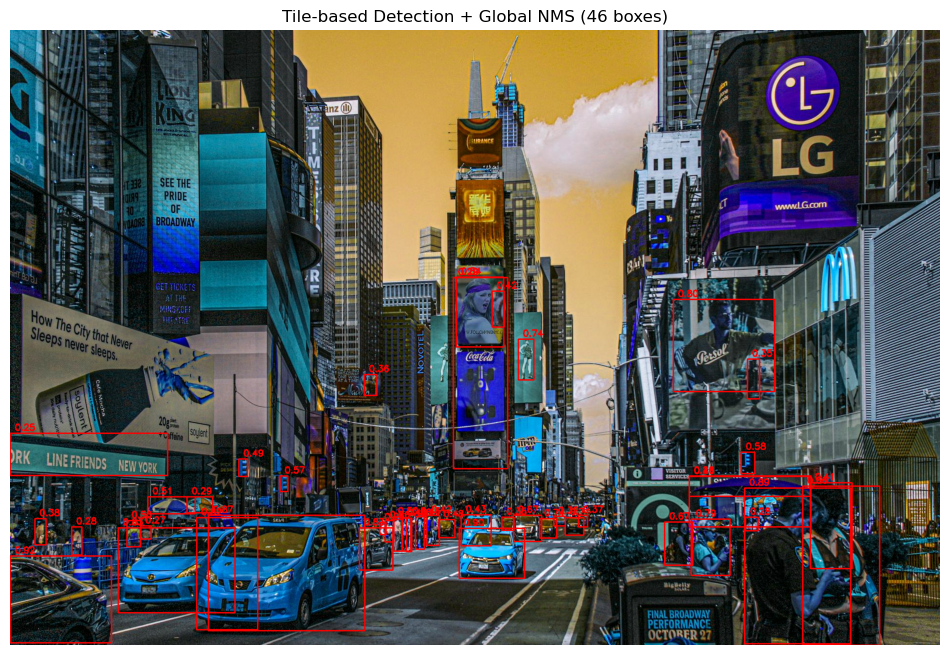

In [302]:
def tile_based_detection(image_path, model, tile_size=1024, overlap=0.2):
    """
    Thực hiện object detection trên ảnh lớn bằng cách chia thành các tile nhỏ
    """
    import cv2
    import numpy as np

    img = cv2.imread(image_path)

    h, w = img.shape[:2]

    stride = int(tile_size * (1 - overlap))

    all_boxes = []
    all_scores = []
    all_classes = []

    for y in range(0, h, stride):
        for x in range(0, w, stride):
            x1, y1 = x, y
            x2, y2 = min(x + tile_size, w), min(y + tile_size, h)

            if x2 - x1 < tile_size // 2 or y2 - y1 < tile_size // 2:
                continue

            tile = img[y1:y2, x1:x2]

            results = model(tile)
            result = results[0]

            if len(result.boxes) > 0:
                boxes = result.boxes.xyxy.cpu().numpy()
                boxes[:, [0, 2]] += x1  # x coordinates
                boxes[:, [1, 3]] += y1  # y coordinates

                scores = result.boxes.conf.cpu().numpy()
                classes = result.boxes.cls.cpu().numpy()

                all_boxes.append(boxes)
                all_scores.append(scores)
                all_classes.append(classes)

    if not all_boxes:
        return np.array([]), np.array([]), np.array([])

    all_boxes = np.vstack(all_boxes)
    all_scores = np.hstack(all_scores)
    all_classes = np.hstack(all_classes)

    return all_boxes, all_scores, all_classes

tile_boxes, tile_scores, tile_classes = tile_based_detection(IMG_PATH, model, tile_size=512, overlap=0.2)

print(f"Tile-based detection found {len(tile_boxes)} boxes before NMS")

if len(tile_boxes) > 0:
    tile_boxes_torch = torch.tensor(tile_boxes, dtype=torch.float32)
    tile_scores_torch = torch.tensor(tile_scores, dtype=torch.float32)

    keep_global = nms(tile_boxes_torch, tile_scores_torch, iou_th=0.5)

    final_boxes = tile_boxes_torch[keep_global].numpy()
    final_scores = tile_scores_torch[keep_global].numpy()

    print(f"After global NMS: {len(final_boxes)} boxes")

    tile_img = draw_boxes(IMG_PATH, final_boxes, scores=final_scores, color=(255,0,0))

    plt.figure(figsize=(12,8))
    plt.imshow(tile_img)
    plt.title(f'Tile-based Detection + Global NMS ({len(final_boxes)} boxes)')
    plt.axis('off')
    plt.show()
else:
    print("No objects detected in tiles")


FPN với ResNet50 backbone

ResNet50 Features:
C3: torch.Size([1, 512, 60, 80])
C4: torch.Size([1, 1024, 30, 40])
C5: torch.Size([1, 2048, 15, 20])


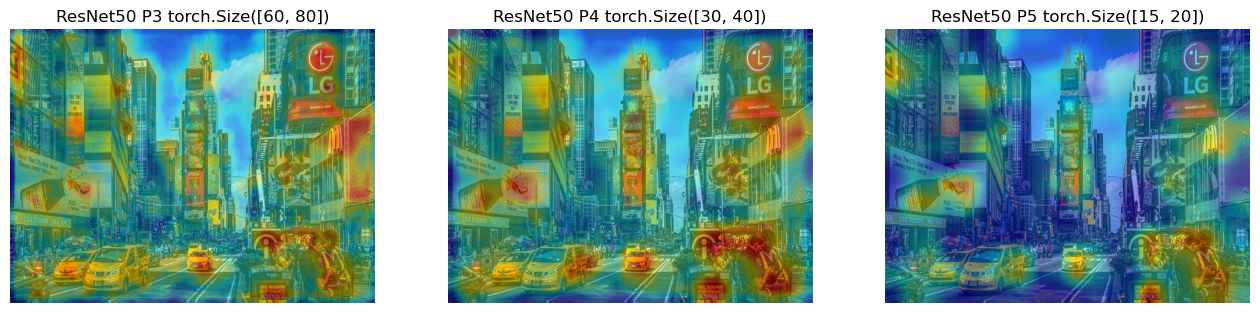

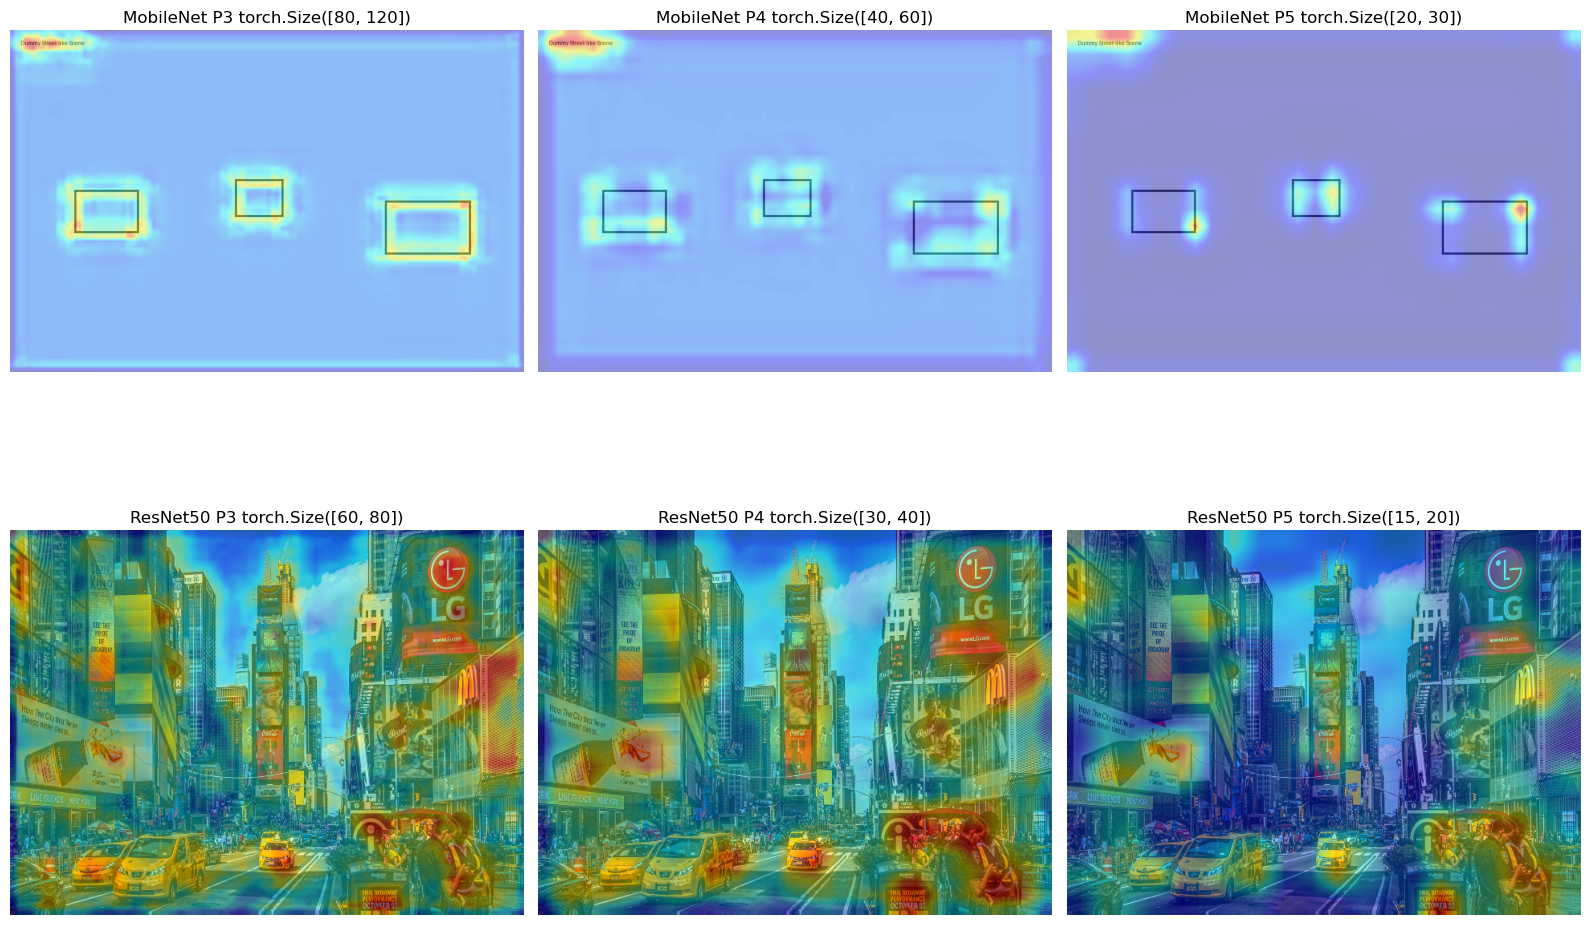

In [303]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.nn.functional as F

resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

backbone = nn.Sequential(
    resnet.conv1,
    resnet.bn1,
    resnet.relu,
    resnet.maxpool,
    resnet.layer1,  # C2: stride 4
    resnet.layer2,  # C3: stride 8
    resnet.layer3,  # C4: stride 16
    resnet.layer4   # C5: stride 32
).eval()

def extract_resnet_features(x):
    """Extract C3, C4, C5 features from ResNet50"""
    features = {}

    x = resnet.conv1(x)
    x = resnet.bn1(x)
    x = resnet.relu(x)
    x = resnet.maxpool(x)

    x = resnet.layer1(x)  # C2
    x = resnet.layer2(x)  # C3
    features['C3'] = x
    x = resnet.layer3(x)  # C4
    features['C4'] = x
    x = resnet.layer4(x)  # C5
    features['C5'] = x

    return features['C3'], features['C4'], features['C5']

img_bgr = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img = pad_to_divisible(img, 32)

img_resized = cv2.resize(img, (640, 480))
t = torch.from_numpy(img_resized).permute(2,0,1).float()/255.0
t = t.unsqueeze(0)

normalize = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
t = (t - normalize) / std

with torch.no_grad():
    C3_resnet, C4_resnet, C5_resnet = extract_resnet_features(t)

print(f"ResNet50 Features:")
print(f"C3: {C3_resnet.shape}")
print(f"C4: {C4_resnet.shape}")
print(f"C5: {C5_resnet.shape}")

class ResNetFPN(nn.Module):
    def __init__(self, c3_ch=512, c4_ch=1024, c5_ch=2048, out_ch=256):
        super().__init__()
        self.l3 = nn.Conv2d(c3_ch, out_ch, 1)
        self.l4 = nn.Conv2d(c4_ch, out_ch, 1)
        self.l5 = nn.Conv2d(c5_ch, out_ch, 1)
        self.s3 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.s4 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

    def forward(self, C3, C4, C5):
        P5 = self.l5(C5)
        P4 = self.l4(C4) + F.interpolate(P5, size=C4.shape[-2:], mode='nearest')
        P3 = self.l3(C3) + F.interpolate(P4, size=C3.shape[-2:], mode='nearest')
        P4 = self.s4(P4)
        P3 = self.s3(P3)
        return P3, P4, P5

with torch.no_grad():
    resnet_fpn = ResNetFPN().eval()
    P3_resnet, P4_resnet, P5_resnet = resnet_fpn(C3_resnet, C4_resnet, C5_resnet)

base_img_bgr_resized = cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR)

resnet_p3_img = heat_to_img(P3_resnet, base_img_bgr_resized)
resnet_p4_img = heat_to_img(P4_resnet, base_img_bgr_resized)
resnet_p5_img = heat_to_img(P5_resnet, base_img_bgr_resized)

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(resnet_p3_img, cv2.COLOR_BGR2RGB))
plt.title(f'ResNet50 P3 {P3_resnet.shape[-2:]}')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(resnet_p4_img, cv2.COLOR_BGR2RGB))
plt.title(f'ResNet50 P4 {P4_resnet.shape[-2:]}')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(resnet_p5_img, cv2.COLOR_BGR2RGB))
plt.title(f'ResNet50 P5 {P5_resnet.shape[-2:]}')
plt.axis('off')
plt.show()

plt.figure(figsize=(16,12))

plt.subplot(2,3,1)
plt.imshow(cv2.cvtColor(a4_p3_img, cv2.COLOR_BGR2RGB))
plt.title(f'MobileNet P3 {P3.shape[-2:]}')
plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(cv2.cvtColor(a4_p4_img, cv2.COLOR_BGR2RGB))
plt.title(f'MobileNet P4 {P4.shape[-2:]}')
plt.axis('off')
plt.subplot(2,3,3)
plt.imshow(cv2.cvtColor(a4_p5_img, cv2.COLOR_BGR2RGB))
plt.title(f'MobileNet P5 {P5.shape[-2:]}')
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(cv2.cvtColor(resnet_p3_img, cv2.COLOR_BGR2RGB))
plt.title(f'ResNet50 P3 {P3_resnet.shape[-2:]}')
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(cv2.cvtColor(resnet_p4_img, cv2.COLOR_BGR2RGB))
plt.title(f'ResNet50 P4 {P4_resnet.shape[-2:]}')
plt.axis('off')
plt.subplot(2,3,6)
plt.imshow(cv2.cvtColor(resnet_p5_img, cv2.COLOR_BGR2RGB))
plt.title(f'ResNet50 P5 {P5_resnet.shape[-2:]}')
plt.axis('off')

plt.tight_layout()
plt.show()

